### Notes

* Votes from 2000 to 2012 are from [Ansolabehere, et al. (2015)](https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/21919).
* Shapefiles are the Census VTDs, which require some name cleaning in 2000-2008, and much more in 2012.  The latter was accomplished with some explicit fixes, followed by human-verified fuzzy matches (see dist_tools for Jaro-Winkler one-liner).

Initial includes and some functions.

In [1]:
import sys; sys.path.insert(0,'../')

from dist_tools import *

%matplotlib inline

fips, epsg, seats, usps = 42, 3364, 18, "pa"
years = [2000, 2004, 2008, 2012]

In [2]:
cols_00_08 = ["D00", "R00", "D04", "R04", "D08", "R08", "DNorm", "RNorm"]
cols_12    = ["D12", "R12"]
cols = cols_00_08 + cols_12

Import the precinct geography from the 2010 Census VTDs, cleaning up the precinct names in the import.

In [3]:
con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

pa_name_query = """SELECT vtd.state, co.name cname, vtd.county cid, vtd, vtd.geoid, 
                     ST_Transform(vtd.geom, 3364) geometry,
                     REGEXP_REPLACE(REGEXP_REPLACE(REGEXP_REPLACE(REGEXP_REPLACE(
                     REGEXP_REPLACE(REGEXP_REPLACE(REGEXP_REPLACE(REGEXP_REPLACE(
                     REGEXP_REPLACE(REGEXP_REPLACE(REGEXP_REPLACE(REGEXP_REPLACE(
                     REGEXP_REPLACE(REGEXP_REPLACE(
                       UPPER(vtd.name), '\.', '', 'g'), ' 0', ' ', 'g'), 'VTD ', 'X-'), ' VOTING DISTRICT', ''),
                                        ' - ', ' ', 'g'), ' WD ', ' W-', 'g'), ',', ''), ' DIST ', ' D-'),
                                        ' PCT ', ' P-'), ' BORO', ''), ' CITY', ''), ' TWP', ''), ' ED ', ' X-'),
                                        ' DIST PCT', ' D-')
                     vname
                   FROM vtd_2010 vtd
                   JOIN counties_2016 co ON
                     co.state  = vtd.state AND
                     co.county = vtd.county
                   WHERE
                     vtd.state = 42
                   ORDER BY cid, vname;"""

prdf = pd.read_sql(pa_name_query, con)
prdf = gpd.GeoDataFrame.from_postgis(pa_name_query, con, geom_col = "geometry", crs = from_epsg(epsg))


The 2000-2008 data from Rodden is pretty clean -- just load it and change the column names.

Note that these have a ton of reallocated votes (and hence fractions).

In [4]:
votes = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/pa/pa_final.tab",
                    sep = "\t", low_memory = False)

votes.rename(columns = {"uspdv2000" : "D00", "uspdv2004" : "D04", "uspdv2008" : "D08", "uspdv2012" : "D12",
                        "usprv2000" : "R00", "usprv2004" : "R04", "usprv2008" : "R08", "usprv2012" : "R12",
                        "ndv" : "DNorm", "nrv" : "RNorm", "geoid10" : "geoid"}, inplace = True)

votes = votes[["geoid"] + cols_00_08]

In [5]:
geo_votes = pd.merge(prdf[["geoid", "geometry"]], votes, how = "outer", on = "geoid")

Now we begin on the messy business of PA 2012 -- we have to clean and then fuzzy match the data to the precincts, with a hard match on county.

In [6]:
pa_co = prdf[["cname", "cid"]].drop_duplicates().reset_index()
pa_co["county"] = pa_co.cname.str.upper()
pa_co = pa_co[["cid", "county"]]

votes_2012 = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/precincts/PA_2012.tab", 
                         delimiter = "\t", low_memory = False)
votes_2012.rename(columns={"precinct_code" : "vtd", 
                           "g2012_USP_dv"  : "D12", 
                           "g2012_USP_rv"  : "R12"}, 
                           inplace = True)
votes_2012 = votes_2012.merge(pa_co, on = "county")
votes_2012 = votes_2012[["county", "cid", "precinct", "D12", "R12"]]

In order to complete the matches, we also have to do a bit of fixing by hand.

In [7]:
pct = votes_2012.precinct.str.upper()
pct = pct.str.replace(" BORO", "")
pct = pct.str.replace(" CITY", "")
pct = pct.str.replace(" TWP", "")
pct = pct.str.replace(" - ", " ")
pct = pct.str.replace(".", "")
pct = pct.str.replace(",", "")
votes_2012.precinct = pct

prdf.loc[prdf.cid == 7,  ["vname"]] = prdf.loc[prdf.cid == 7,  ["vname"]].replace({"vname" : {' [0-9] ' : " "}}, regex = True)
prdf.loc[prdf.cid == 95, ["vname"]] = prdf.loc[prdf.cid == 95, ["vname"]].replace({"vname" : {r'LOWER SAUCON X-([0-9]) [A-Z ]*' :
                                                                                              r'LOWER SAUCON X-\1'}}, regex = True)
prdf.loc[prdf.cid == 37, ["vname"]] = prdf.loc[prdf.cid == 37, ["vname"]].replace({"vname" : {r'BLOOMSBURG [TOWN D-]*([1-4])[STNDH WARD]*([ X\-1-2]*)' :
                                                                                              r'BLOOMSBURG W-\1 \2'}}, regex = True)
prdf.loc[prdf.cid == 37, ["vname"]] = prdf.loc[prdf.cid == 37, ["vname"]].replace({"vname" : {r'BERWICK ([1-4])[STNDH WARD].*' :
                                                                                              r'BERWICK W-\1'}}, regex = True)

prdf.loc[(prdf.cid == 11) & (prdf.vname == "MOUNT PENN D-1"), "vname"] = "MT PENN D-1"

prdf.loc[(prdf.cid == 25) & (prdf.vname == "EAST PENN D-NORTH"), "vname"] = "EAST PENN X-NORTH"

prdf.loc[(prdf.cid == 107) & (prdf.vname == "NORTH MANHEIM D-PCT 1"),       "vname"] = "NORTH MANHEIM P-1"
prdf.loc[(prdf.cid == 107) & (prdf.vname == "NORTH MANHEIM D-MELLOTS P-2"), "vname"] = "NORTH MANHEIM P-2"
prdf.loc[(prdf.cid == 107) & (prdf.vname == "NORTH MANHEIM D-ADAMSDALE"),   "vname"] = "NORTH MANHEIM P-3"

votes_2012.loc[(votes_2012.cid == 25) & (votes_2012.precinct == "SUMMIT HILL D-3 X-1"), "precinct"] = "SUMMIT HILL W-3 D-1"
votes_2012.loc[(votes_2012.cid == 25) & (votes_2012.precinct == "SUMMIT HILL D-3 X-2"), "precinct"] = "SUMMIT HILL W-3 D-2"

Hurrah for fuzzy matching!!

In [8]:
votes_2012['vname'] = "NOMATCH"
for cid in list(pa_co["cid"]):
    
    # Alternately:  .apply(lambda x: process.extractOne(x, prdf[prdf.cid == cid]["vname"])[0])
    votes_2012.loc[votes_2012.cid == cid, 'vname'] = votes_2012[votes_2012.cid == cid]['precinct'].apply(lambda x: jf_jw_match(x, prdf[prdf.cid == cid]["vname"])[0])
    

In [9]:
votes_2012 = votes_2012.merge(prdf, on = ["cid", "vname"], how = "outer")\
                       [["state", "cid", "cname", "precinct", "D12", "R12", "geoid"]]

Merge everything together.

In [10]:
pr_votes = pd.merge(geo_votes, votes_2012, how = "outer").fillna(0)\
              [["D00", "R00", "D04", "R04", "D08", "R08", "D12", "R12", "geometry"]]

In [11]:
pr_votes["DFrac"] = pr_votes["D00"] / (pr_votes["D00"] + pr_votes["R00"])
output_geojson(pr_votes.set_geometry(pr_votes.geometry.simplify(10)), var = "DFrac", fname = "mapped/pa_2000.geojson")

pr_votes["DFrac"] = pr_votes["D04"] / (pr_votes["D04"] + pr_votes["R04"])
output_geojson(pr_votes.set_geometry(pr_votes.geometry.simplify(10)), var = "DFrac", fname = "mapped/pa_2004.geojson")

pr_votes["DFrac"] = pr_votes["D08"] / (pr_votes["D08"] + pr_votes["R08"])
output_geojson(pr_votes.set_geometry(pr_votes.geometry.simplify(10)), var = "DFrac", fname = "mapped/pa_2008.geojson")

pr_votes["DFrac"] = pr_votes["D12"] / (pr_votes["D12"] + pr_votes["R12"])
output_geojson(pr_votes.set_geometry(pr_votes.geometry.simplify(10)), var = "DFrac", fname = "mapped/pa_2012.geojson")

Get the tract to precinct mapping directly from postgres.

In [12]:
tr_rn = get_tr_rn("pa").to_crs(epsg = epsg)

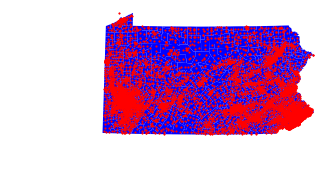

In [13]:
ax = tr_rn.plot(color = "blue", figsize = (2, 2))
pr_votes.centroid.plot(color = "red", markersize = 0.5, ax = ax)
ax.set_axis_off()

In [14]:
tract_votes = merge_tract_number(tr_rn, pr_votes)[["D00", "R00", "D04", "R04", "D08", "R08", "D12", "R12"]]
tract_votes.to_csv("votes/pa.csv")

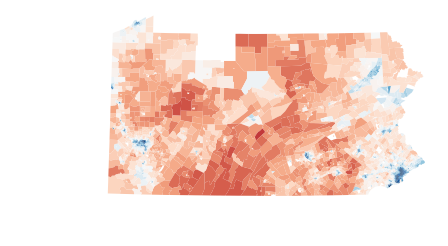

In [2]:
map_sanity_check("pa", 2012, epsg)